#

In [12]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from slices import display_multi_slices, get_sdf_image
from tqdm.auto import tqdm
from src.data.synthetic_data import sphere_data, square_data
from marching_squares import get_img_marching_squares, display_multiple_shapes_sdf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device="cpu"
device
from src.models.Sirenlayer import SirenNet
from src.optimize import optimize_nise_vf
from src.results.display import display_result

In [14]:
from src.loss.utils import * 
from src.loss.utils import project_pc
from src.loss.loss_data import loss_data,loss_normalign,loss_shape_data
from src.loss import compute_EMD
import torch
from src.results.display import * 
from src.optimize import optimize_nise_vf

# Loading the Data 
We provide here in 2D. See another notebook for 3D. 


(200, 200)


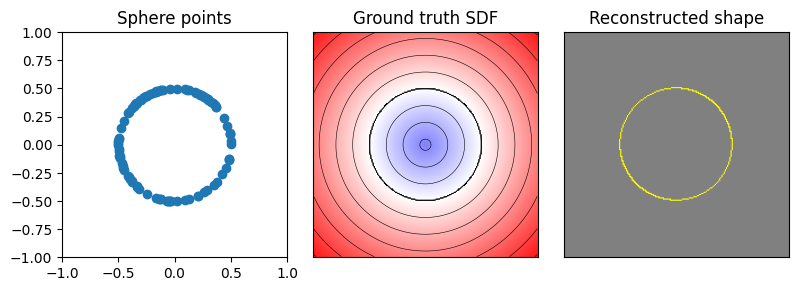

In [18]:
pc0, nc0, pts_hints0, gt_sdf_hints0, gt_grad_hints0, coords, sdf_coords = sphere_data(
    10000, 100000
)

# constant vector field (a single vector)
vf = torch.tensor([0.3, 0.0], device=device)


fig, axs = plt.subplots(1, 3, figsize=(8, 15))
pc_numpy = pc0.detach().cpu().numpy()
axs[0].scatter(pc_numpy[::100, 0], pc_numpy[::100, 1])
axs[0].set_aspect(1.0 / axs[0].get_data_ratio(), adjustable="box")
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-1, 1])
axs[0].set_title("Sphere points")
sdf_numpy = sdf_coords.detach().cpu().numpy()
axs[1].imshow(get_sdf_image(sdf_numpy))
axs[1].contour(sdf_numpy, 10, colors="k", linewidths=0.4, linestyles="solid")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Ground truth SDF")
print(sdf_numpy.shape)
rec_img = get_img_marching_squares(sdf_numpy)
axs[2].imshow(rec_img)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Reconstructed shape")


plt.tight_layout()
plt.show()

## Specify your model here :

In [24]:
# Use SIrenNet 
npl = 128
depth = 3
true_net = SirenNet(dim_in=2, dim_out=1, num_layers=depth, dim_hidden=npl, skip=[]).to(
    device
)
optimizer=None
# If you want to use tinycu
if True:
    from src.models.tiny_cu import SDF_TCNN  
    true_net = SDF_TCNN().to(device)
    optimizer = lambda model: torch.optim.Adam([
            {'name': 'encoding', 'params': model.encoder.parameters()},
            {'name': 'net', 'params': model.backbone.parameters(), 'weight_decay': 1e-6},
        ], lr=1e-4, betas=(0.9, 0.99), eps=1e-15)
    optimizer = optimizer(true_net)

initialisation Xavier True fix_init False



# Actual training :

In [25]:
nepochs=5000

starting loss, lambda_pc=1, lambda_eik=0.001, lambda_hint=0, lambda_lse=2, lambda_gc=0.01, lambda_emd=0


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s, loss=0.289]

lambda_emd is null


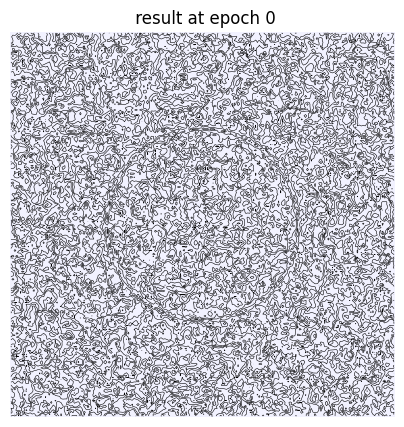

Training:  40%|███▉      | 1999/5000 [00:24<00:35, 85.05it/s, loss=0.00362]

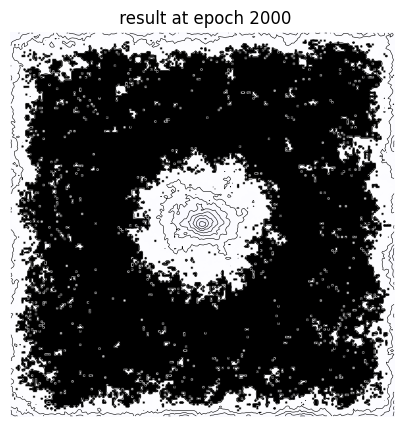

Training:  80%|███████▉  | 3999/5000 [00:49<00:11, 83.42it/s, loss=7.58e-5] 

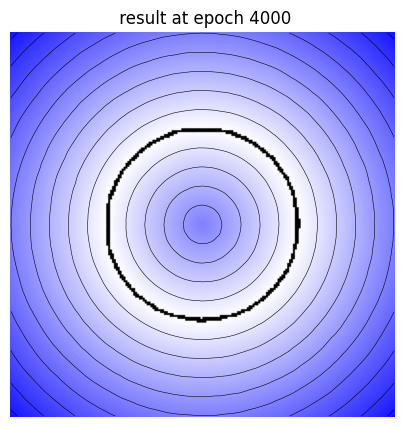

Training: 100%|██████████| 5000/5000 [01:02<00:00, 80.42it/s, loss=4.62e-5]

Optimizing NN took 62.18 s.


In [ ]:
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
# nepochs = 10000

pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    hints0=pts_hintst0,
    gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    lambda_pc=1,# 
    lambda_eik=0.001, # eikonal,
    lambda_hint=0, # used but need ground truth,
    lambda_lse=2, # not used,
    lambda_gc=0.01, #geometric consistency,
    lambda_emd=0, # lambda EMD,
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=True,
    follow_paper=False,
    list_loss=list_loss,
    optimizer=optimizer,
)


# Display Results:

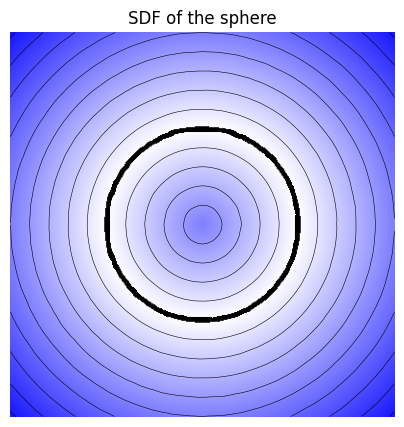

In [27]:
display_result(true_net, resolution=400, figsize=(14, 5),title="SDF of the sphere",eps=0.01)

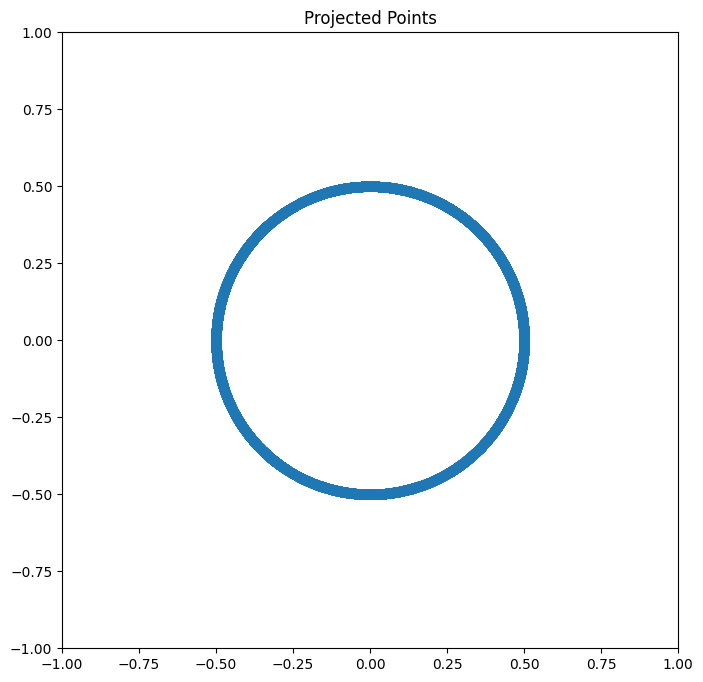

In [28]:
display_projection(true_net,pc_t0)


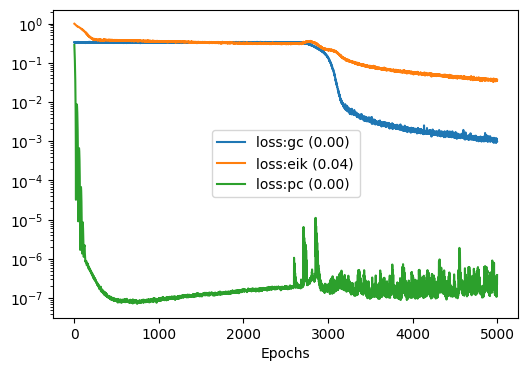

In [30]:
display_loss(list_loss)